# Create initial and boundary conditions for BGC of ACCESS-OM2*

### A few notes:

1. Directory structure
    - directories are based on `basepath`
    - `input` contains input data
    - `tmp` is where the regridded data will be stored initially (**to be deleted manually after regridding is finished if you want to re-create fresh files**).
    - `1deg, 025deg, 01deg` are where the regridded data used for model simulations will be stored (permanent locations).
    - `insource` is where the input files are symlinked from.
    - `cplpath` is the parent to the dirs that i2o.nc and o2i.nc are copied from.

0. To run ACCESS-OM2* with BGC, the following files are required:
    - bgc_param.nc (parameters)
    - co2_iaf.nc or co2_ryf.nc (atmospheric co2 concentrations)
    - csiro_bgc.res.nc (initial conditions)
    - csiro_bgc_sediment.res.nc (initial sediment conditions)
    - dust.nc (dust deposition for iron)

0. In addition, the following files need to be updated by adding extra coupling tracers for ice BGC (initialised to zeros for simplicity):
    - i2o.nc
    - o2i.nc

0. There are a few options for BGC initial conditions. The current version of this script supports generation of initial conditions either from:
    - access-om2-1deg_omip2_cycle5 (adic,dic,alk)
    - WOA13v2 (no3,o2; OMIP protocol)
    - GLODAPv2 2016b (no3,o2,adic,dic,alk)
    - FeMIP median (fe; mol L-1)
    - 0.01 mmol m-3 is given to phy,zoo,det,caco3.

0. Before regridding, input data are extrapolated over land to avoid missing values over the regridded ocean in case slight changes in the model bathymetry occurs in the future. This is done using `cdo fillmiss`.

0. WOMBAT wants these fields in the units of mmol m-3 for all tracers except for iron (umol m-3). Therefore, appropriate unit conversion is needed if the input data are provided in different units. 

0. This script should be run using `gadi_jupyter` by requesting the maximum memory for a whole node i.e., `gadi_jupyter -m 192Gb -q normal -n 27 -t 15:00:00`.

# Load relevant modules

In [1]:
%matplotlib inline
from scipy.interpolate import griddata,interpn
import numpy as np
import xarray as xr
import xesmf as xe
from pathlib import Path
import os

In [2]:
import climtas.nci
climtas.nci.GadiClient(malloc_trim_threshold='64kib')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 27
Total threads: 27,Total memory: 192.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45997,Workers: 27
Dashboard: /proxy/8787/status,Total threads: 27
Started: Just now,Total memory: 192.00 GiB
Comm: tcp://10.6.44.33:45661,Total threads: 1
Dashboard: /proxy/36953/status,Memory: 7.11 GiB
Nanny: tcp://127.0.0.1:46815,


# Set up directories

In [2]:
# res_list = ['1','025','01']
res_list = ['01']

# basepath = '/g/data/v45/hh0162/projects/icebgc/prep_omip2/input_om2-bgc/'
basepath = '/g/data/v45/aek156/input_om2-bgc/'
inpath = basepath+'input/'
tmppath = basepath+'tmp/'

# insource is where the input files are copied/symlinked from
insource = '/g/data/ik11/inputs/BGC/'

# cplpath is parent to dirs that i2o.nc and o2i.nc are copied from
cplpath = '/g/data/ik11/inputs/access-om2/input_20201102/'

# create dirs if they don't already exist
Path(inpath).mkdir(parents=True, exist_ok=True)
Path(tmppath).mkdir(parents=True, exist_ok=True)
for r in res_list:
    Path(basepath+r+'deg').mkdir(parents=True, exist_ok=True)

In [3]:
%%bash -s "$insource" "$cplpath" "$basepath" "$inpath" "{" ".join(res_list)}"
insource=$1
cplpath=$2
basepath=$3
inpath=$4
res=$5
cp -nprs ${insource}input/* ${inpath} # symlink input files from insource to inpath if they aren't already there
for ir in $res
do # copy coupler files from cplpath to basepath if they aren't already there
    cp -np `realpath ${cplpath}/cice_${ir}deg/i2o.nc` ${basepath}/${ir}deg
    cp -np `realpath ${cplpath}/cice_${ir}deg/o2i.nc` ${basepath}/${ir}deg
done

# Create `csiro_bgc.res.nc`.

- The input options `input_list` are:
    - IRON = FEMIP median iron (mol/L)
    - TAlk,TCO2,PI_TCO2,NO3,oxygen = GLODAPv2 2016b (umol/kg)
    - no3, o2 = WOA2013v2 (mmol/m3, ml/L)
    - dic,adic,alk = 1deg_jra55_iaf_omip2_cycle5_restart304 (mmol/m3 for all)
    
- `wombat_list` contains the names of variables that WOMBAT wants. The choices are `fe,dic,adic,alk,no3,o2`.

- `wombat_list` must match the order of `input_list`. For example, if `input_list = ['NO3','oxygen']`, then `wombat_list = ['no3','o2']`

- `res_list` is the output resolution you want to regrid to.

- mean/min/max of both input and output data are printed to make sure that regridded values are reasonable and contains no NaNs.

### Define `my_choice` to choose your input data based on your configuration, either `master+bgc`, `01deg_jra55v140_iaf_cycle4`, or `iamip2`.
**WARNING:** if you change `my_choice` you must delete the files in `tmp` to create new versions!

In [5]:
# my_choice = 'master+bgc' # 'master+bgc', '01deg_jra55v140_iaf_cycle4', or 'iamip2'
my_choice = '01deg_jra55v140_iaf_cycle4' # 'master+bgc', '01deg_jra55v140_iaf_cycle4', or 'iamip2'

BGC_vars = { 
    'master+bgc':                 ['NO3','oxygen','PI_TCO2','TAlk','TCO2','IRON'],
    '01deg_jra55v140_iaf_cycle4': ['NO3','oxygen','dic',    'alk', 'adic','IRON'],
    'iamip2':                     ['no3','o2',    'PI_TCO2','TAlk','TCO2','IRON']
}

input_list = BGC_vars[my_choice]
wombat_list = ['no3','o2','dic'  ,'alk' ,'adic',    'fe'] # must be in the same order as in BGC_vars

wombat_attrs = { # netcdf attributes
                'no3': {'long_name': 'nitrate', 'units': 'mmol/m^3'},
                'o2': {'long_name': 'dissolved oxygen', 'units': 'mmol/m^3'},
                'dic': {'long_name': 'natural dissolved inorganic carbon', 'units': 'mmol/m^3'},
                'alk': {'long_name': 'alkalinity', 'units': 'mmol/m^3'},
                'adic': {'long_name': 'natural + anthropogenic dissolved inorganic carbon', 'units': 'mmol/m^3'},
                'fe': {'long_name': 'iron', 'units': 'umol/m^3'},  # NB: the only one with different units
                'phy': {'long_name': 'phytoplankton', 'units': 'mmol/m^3'},
                'zoo': {'long_name': 'zooplankton', 'units': 'mmol/m^3'},
                'det': {'long_name': 'detritus', 'units': 'mmol/m^3'},
                'caco3': {'long_name': 'calcium carbonate', 'units': 'mmol/m^3'}
                }

In [6]:
for ir in range(np.size(res_list)):
    
    for it in range(np.size(wombat_list)):

        tmpoutfile = tmppath+wombat_list[it]+'_init_'+res_list[ir]+'deg.nc'
        
        if os.path.exists(tmpoutfile):
            print('-- skipping', tmpoutfile, '(file already exists)')
        else:
            if input_list[it] == 'IRON':
                ds_in = xr.open_dataset(inpath+'FEMIP_model_median_iron_2016_fillmiss.nc')
                #rename the coordinates to the MOM coordinate names to enable interpolation.
                ds_in = ds_in.rename(({'LON':'xt_ocean', 'LAT':'yt_ocean', 'DEPTH':'st_ocean'}))              
            elif input_list[it] == 'no3':
                ds_in = xr.open_dataset(inpath+'woa13_nitrate_OMIPinit_fillmiss.nc',decode_times=False)
                ds_in = ds_in.rename(({'lon':'xt_ocean', 'lat':'yt_ocean', 'depth':'st_ocean'}))
                ds_in = ds_in.isel(time=0,drop=True)
            elif input_list[it] == 'o2':
                ds_in = xr.open_dataset(inpath+'woa13_oxygen_OMIPinit_fillmiss.nc',decode_times=False)
                ds_in = ds_in.rename(({'lon':'xt_ocean', 'lat':'yt_ocean', 'depth':'st_ocean'}))
                ds_in = ds_in.isel(time=0,drop=True)
            elif input_list[it] in ['alk','adic','dic']:
                ds_in = xr.open_dataset(inpath+'1deg_jra55_iaf_omip2_cycle5_restart304_csiro_bgc.res_fillmiss.nc')
                ds_in = ds_in.isel(time=0,drop=True)
            elif input_list[it] in ['TAlk','TCO2','PI_TCO2','NO3','oxygen']:
                ds_in = xr.open_dataset(inpath+'GLODAPv2.2016b.'+input_list[it]+'_fillmiss.nc')
                ds_in = ds_in.rename(({'lon':'xt_ocean', 'lat':'yt_ocean', 'depth_surface':'st_ocean'}))
                #the vertical coordinate (depth_surface) in GLODAPv2.2016b is wrong (it is index, not depth values).
                #derive depth from FEMIP iron data (they are interpolated onto the same depths).
                ds_tmp = xr.open_dataset(inpath+'FEMIP_model_median_iron_2016_fillmiss.nc')
                ds_in['st_ocean'] = ds_tmp['DEPTH']
            else:
                exit()
            ds_in = ds_in.rename({input_list[it]:wombat_list[it]})


            #first convert the lon coordinate system to the standard system (0-360) if not already in the standard system (e.g. -180 to 180)
            #retain lon values less than 360, otherwise subtract 360
            ds_in['xt_ocean'] = ds_in['xt_ocean'].where(ds_in['xt_ocean']<360,ds_in['xt_ocean']-360)
            #retain lon values greater than 0, otherwise add 360
            ds_in['xt_ocean'] = ds_in['xt_ocean'].where(ds_in['xt_ocean']>0,ds_in['xt_ocean']+360)

            #now convert to the MOM lon coordinate system, which spans from -280 to 80 (yes, a bit weird)
            #retain lon values less than 80, otherwise subtract 360
            ds_in['xt_ocean'] = ds_in['xt_ocean'].where(ds_in['xt_ocean']<80,ds_in['xt_ocean']-360)
            #retain lon values greater than -280, otherwise add 360
            ds_in['xt_ocean'] = ds_in['xt_ocean'].where(ds_in['xt_ocean']>-280,ds_in['xt_ocean']+360)


            #read target grid
            if res_list[ir] == '1':
                ds_tar = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_20201102/mom_1deg/ocean_temp_salt.res.nc')
                ds_gri = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc')
            elif res_list[ir] == '025':
                ds_tar = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_20201102/mom_025deg/ocean_temp_salt.res.nc')
                ds_gri = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc')        
            elif res_list[ir] == '01':
                ds_tar = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_20201102/mom_01deg/ocean_temp_salt.res.nc')
                ds_gri = xr.open_dataset('/g/data/ik11/grids/ocean_grid_01.nc')
            else:
                exit()
            #rename to lon and lat so that xesmf understands
            ds_gri = ds_gri.rename({'geolon_t': 'lon', 'geolat_t': 'lat'})
            ds_tar = ds_tar.rename({'ZT': 'st_ocean', 'GRID_Y_T': 'yt_ocean', 'GRID_X_T':'xt_ocean'})

            #vertical 1-d interpolation first
            ar_zz = np.zeros((np.size(ds_tar['st_ocean']),np.size(ds_in['yt_ocean']),np.size(ds_in['xt_ocean'])))
            ar_in = ds_in[wombat_list[it]].values
            for ix in range(np.size(ar_zz,2)):
                for iy in range(np.size(ar_zz,1)):
                    #fill_value=None will extrapolate
                    ar_zz[:,iy,ix] = interpn((ds_in['st_ocean'].values,),ar_in[:,iy,ix],ds_tar['st_ocean'].values,
                                            method="linear",fill_value=None,bounds_error=False)         
            ds_zz = ds_in.copy()
            ds_zz = ds_zz.isel(st_ocean=0,drop=True)
            ds_zz = ds_zz.assign_coords(st_ocean=ds_tar['st_ocean'])
            if input_list[it] in ['adic','alk','dic']:
                ds_gri_1deg = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc')
                ds_zz['lon'] = (['yt_ocean','xt_ocean'],ds_gri_1deg['geolon_t'].values)
                ds_zz['lat'] = (['yt_ocean','xt_ocean'],ds_gri_1deg['geolat_t'].values)
            else:        
                ds_zz = ds_zz.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})
            ds_zz[wombat_list[it]] = (['st_ocean','yt_ocean','xt_ocean'],ar_zz)           
            #use bilinear. i compared with nearest_s2d but the differences are minimal.
            regridder = xe.Regridder(ds_zz,ds_gri,method='bilinear',periodic=True)
            regridder        
            ds_tar = ds_tar.rename({'temp':wombat_list[it]})
            for attr in ['valid_range', 'longname', 'standard_name', 'units']:
                try:
                    del ds_tar[wombat_list[it]].attrs[attr]
                except KeyError:
                    pass
            for iz in range(np.size(ds_zz['st_ocean'])):
                ds_tar[wombat_list[it]][:,iz,:,:] = regridder(ds_zz[wombat_list[it]].isel(st_ocean=iz))
            #some interpolated values are NaNs, so interpolate_na with the following options to fill in NaNs.
            #dim='st_ocean' is essential. 'xt_ocean' produces NaNs.
            #method='nearest' is essential. 'linear' gives extreme values.
            #fill_value='extrapolate' is essential. without it, still NaNs exist.
            ds_tar[wombat_list[it]] = ds_tar[wombat_list[it]].interpolate_na(dim='st_ocean',method='nearest',fill_value="extrapolate")
            print(['input: ',ds_in[wombat_list[it]].mean(),ds_in[wombat_list[it]].min(),ds_in[wombat_list[it]].max()])
            print(['output: ',ds_tar[wombat_list[it]].mean(skipna=False),ds_tar[wombat_list[it]].min(skipna=False),ds_tar[wombat_list[it]].max(skipna=False)])
            #set negative values to zero (negative values exist in NO3 input) 
            ds_tar[wombat_list[it]] = ds_tar[wombat_list[it]].where(ds_tar[wombat_list[it]]>0,0)

            #unit conversion relevant for fe and o2
            if input_list[it] == 'IRON':
                #conversion from mol l-1 to umol m-3
                ds_tar[wombat_list[it]] = ds_tar[wombat_list[it]]*1e9
            elif input_list[it] == 'o2':
                #conversion from ml l-1 to mmol m-3
                ds_tar[wombat_list[it]] = ds_tar[wombat_list[it]]*44.661
            elif input_list[it] in ['TAlk','TCO2','PI_TCO2','NO3','oxygen']:
                #conversion from umol kg-1 to mmol m-3
                ds_tar[wombat_list[it]] = ds_tar[wombat_list[it]]*1.025            
            else:
                exit()
            #rename to what wombat wants.
            ds_tar = ds_tar.rename(({'xt_ocean':'xaxis_1', 'yt_ocean':'yaxis_1', 'st_ocean':'zaxis_1', 'time':'Time'}))    

    # convert units of 'degree_' to 'degrees_' so MOM will be able to infer the axis meaning
    # https://github.com/mom-ocean/MOM5/blob/1d9af9d262b/src/shared/axis_utils/axis_utils.F90#L92-L99
            for dim in ds_tar.dims:
                try:
                    units = ds_tar[dim].attrs['units'].lower()
                    if units.startswith('degree_'):
                        ds_tar[dim].attrs['units'] = units.replace('degree_', 'degrees_', 1)
                except KeyError:
                    pass

            ds_tar = ds_tar.drop('salt', errors='ignore')  # remove 'salt' inherited from ocean_temp_salt.res.nc
            ds_tar.attrs.pop('history', None)

            ds_tar.to_netcdf(tmpoutfile,
                             unlimited_dims='Time',
                             encoding={wombat_list[it]:{'zlib': True,'complevel': 9}})
            print('created', tmpoutfile, 'from input', input_list[it])

-- skipping /g/data/v45/aek156/input_om2-bgc/tmp/no3_init_01deg.nc (file already exists)
-- skipping /g/data/v45/aek156/input_om2-bgc/tmp/o2_init_01deg.nc (file already exists)
-- skipping /g/data/v45/aek156/input_om2-bgc/tmp/dic_init_01deg.nc (file already exists)
-- skipping /g/data/v45/aek156/input_om2-bgc/tmp/alk_init_01deg.nc (file already exists)
-- skipping /g/data/v45/aek156/input_om2-bgc/tmp/adic_init_01deg.nc (file already exists)
-- skipping /g/data/v45/aek156/input_om2-bgc/tmp/fe_init_01deg.nc (file already exists)


### Combine the regridded output for each tracer into a single `csiro_bgc.res.nc`. Also add tracers that are set to constant (0.01 mmol m-3; phy,zoo,det,caco3).
- `dic_eq_adic = True` will set dic to be identical to adic (not using it for now).

In [7]:
# res_list = ['1','025','01']

dic_eq_adic = False

for ir in range(np.size(res_list)):
    
    for it in range(np.size(wombat_list)):
        ds_tar = xr.open_dataset(tmppath+wombat_list[it]+'_init_'+res_list[ir]+'deg.nc')
        try:
            ds_tar_all = ds_tar_all.assign(ds_tar)
        except NameError:
            ds_tar_all = ds_tar.copy()
    ds_new = ds_tar[wombat_list[-1]].copy()
    if dic_eq_adic:
        ds_tar_all = ds_tar_all.assign(dic=ds_new)

    ds_new[:,:,:,:] = 0.01
    ds_tar_all = ds_tar_all.assign(phy=ds_new)
    ds_tar_all = ds_tar_all.assign(zoo=ds_new)
    ds_tar_all = ds_tar_all.assign(det=ds_new)
    ds_tar_all = ds_tar_all.assign(caco3=ds_new)

    for k, attrs in wombat_attrs.items():
        ds_tar_all[k].attrs = attrs

    ds_tar_all = ds_tar_all.drop('salt', errors='ignore')  # remove 'salt' inherited from ocean_temp_salt.res.nc
    ds_tar_all.attrs.pop('history', None)

    ds_tar_all.to_netcdf(tmppath+'csiro_bgc.res_'+res_list[ir]+'deg.nc')
    del ds_tar_all
    print(res_list[ir],'done')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


01 done


# Creation of `co2_iaf.nc` and `co2_ryf.nc`.

1. Create atmospheric CO2 concentration (boundary conditions). One for IAF and one for RYF.
1. Prescribe annual mean (for saving storage) and global mean (for simplicity) data.
1. Follow OMIP2 protocol until 2014. From 2015-2021, use the global average data from https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_annmean_gl.txt (as of 30 Jun 15:43:11 2022). For 2022 and beyond, use exponential extrapolation from final 20 years of data.
1. For RYF, apply the mean of CO2 between 1957-58 (representative of 01/01/1958, the start of IAF). 

In [4]:
from cftime import DatetimeNoLeap
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [5]:
# combined atmospheric co2 data for input from 1850 onward
# OMIP2 protocol for 1850-2014.
# NOAA GML DATA for 2015 onward.
# atmco2_data = [284.32, 284.45, 284.60, 284.73, 284.85, 284.94, 285.05, 285.20, 285.37, 285.54, 285.74, 285.93, 286.10, 286.27, 286.44, 286.61, 286.78, 286.95, 287.10, 287.22, 287.35, 287.49, 287.66, 287.86, 288.06, 288.29, 288.52, 288.75, 288.99, 289.22, 289.47, 289.74, 290.02, 290.26, 290.51, 290.80, 291.10, 291.41, 291.76, 292.11, 292.46, 292.82, 293.17, 293.48, 293.79, 294.08, 294.36, 294.65, 294.95, 295.30, 295.67, 296.01, 296.32, 296.65, 296.95, 297.29, 297.66, 298.10, 298.52, 298.94, 299.38, 299.83, 300.35, 300.91, 301.42, 301.94, 302.48, 303.01, 303.45, 303.81, 304.25, 304.60, 304.94, 305.27, 305.63, 305.81, 305.95, 306.18, 306.33, 306.49, 306.62, 306.82, 307.09, 307.40, 307.78, 308.23, 309.01, 309.76, 310.29, 310.85, 311.36, 311.81, 312.17, 312.39, 312.41, 312.38, 312.39, 312.49, 312.52, 312.63, 312.82, 313.01, 313.34, 313.73, 314.09, 314.41, 314.70, 314.99, 315.34, 315.81, 316.62, 317.30, 318.04, 318.65, 319.33, 319.82, 320.88, 321.48, 322.39, 323.25, 324.78, 325.40, 327.35, 329.91, 330.76, 330.83, 331.54, 333.35, 335.01, 336.60, 338.70, 340.06, 340.64, 342.27, 344.01, 345.46, 346.90, 348.77, 351.28, 352.89, 354.07, 355.35, 356.23, 356.92, 358.25, 360.24, 362.00, 363.25, 365.93, 367.84, 369.12, 370.67, 372.83, 375.41, 376.99, 378.91, 381.01, 382.60, 384.74, 386.28, 388.72, 390.94, 393.02, 395.72, 397.55, 399.65, 403.08, 405.22, 407.62, 410.07, 412.44] # 2015- is from NOAA GML as of Oct 5 13:17:31 2021
atmco2_data = [284.32, 284.45, 284.60, 284.73, 284.85, 284.94, 285.05, 285.20, 285.37, 285.54, 285.74, 285.93, 286.10, 286.27, 286.44, 286.61, 286.78, 286.95, 287.10, 287.22, 287.35, 287.49, 287.66, 287.86, 288.06, 288.29, 288.52, 288.75, 288.99, 289.22, 289.47, 289.74, 290.02, 290.26, 290.51, 290.80, 291.10, 291.41, 291.76, 292.11, 292.46, 292.82, 293.17, 293.48, 293.79, 294.08, 294.36, 294.65, 294.95, 295.30, 295.67, 296.01, 296.32, 296.65, 296.95, 297.29, 297.66, 298.10, 298.52, 298.94, 299.38, 299.83, 300.35, 300.91, 301.42, 301.94, 302.48, 303.01, 303.45, 303.81, 304.25, 304.60, 304.94, 305.27, 305.63, 305.81, 305.95, 306.18, 306.33, 306.49, 306.62, 306.82, 307.09, 307.40, 307.78, 308.23, 309.01, 309.76, 310.29, 310.85, 311.36, 311.81, 312.17, 312.39, 312.41, 312.38, 312.39, 312.49, 312.52, 312.63, 312.82, 313.01, 313.34, 313.73, 314.09, 314.41, 314.70, 314.99, 315.34, 315.81, 316.62, 317.30, 318.04, 318.65, 319.33, 319.82, 320.88, 321.48, 322.39, 323.25, 324.78, 325.40, 327.35, 329.91, 330.76, 330.83, 331.54, 333.35, 335.01, 336.60, 338.70, 340.06, 340.64, 342.27, 344.01, 345.46, 346.90, 348.77, 351.28, 352.89, 354.07, 355.35, 356.23, 356.92, 358.25, 360.24, 362.00, 363.25, 365.93, 367.84, 369.12, 370.67, 372.83, 375.41, 376.99, 378.91, 381.01, 382.60, 384.74, 386.28, 388.72, 390.94, 393.02, 395.72, 397.55, 399.65, 403.09, 405.22, 407.62, 410.07, 412.44, 414.72 ] # 2015- is from NOAA GML as of 30 Jun 15:43:11 2022

# Fit the function a * np.exp(b * t) + c to extrapolate beyond the data
num_to_fit = 20
atmco2_to_fit = atmco2_data[-num_to_fit:]
fitparams, _ = curve_fit(lambda t, a, b, c: a * np.exp(b * t) + c, range(0, len(atmco2_to_fit)), atmco2_to_fit)

def fit(index, fitparams=fitparams, offset=len(atmco2_data)-num_to_fit):
    return fitparams[0] * np.exp(fitparams[1] * (index - offset)) + fitparams[2]

atmco2 = atmco2_data + [ fit(i) for i in range(len(atmco2_data), len(atmco2_data) + 10 ) ]

date_iaf = [ DatetimeNoLeap(1850 + i, 7, 1) for i in range(0, len(atmco2)) ]

In [6]:
atmco2

[284.32,
 284.45,
 284.6,
 284.73,
 284.85,
 284.94,
 285.05,
 285.2,
 285.37,
 285.54,
 285.74,
 285.93,
 286.1,
 286.27,
 286.44,
 286.61,
 286.78,
 286.95,
 287.1,
 287.22,
 287.35,
 287.49,
 287.66,
 287.86,
 288.06,
 288.29,
 288.52,
 288.75,
 288.99,
 289.22,
 289.47,
 289.74,
 290.02,
 290.26,
 290.51,
 290.8,
 291.1,
 291.41,
 291.76,
 292.11,
 292.46,
 292.82,
 293.17,
 293.48,
 293.79,
 294.08,
 294.36,
 294.65,
 294.95,
 295.3,
 295.67,
 296.01,
 296.32,
 296.65,
 296.95,
 297.29,
 297.66,
 298.1,
 298.52,
 298.94,
 299.38,
 299.83,
 300.35,
 300.91,
 301.42,
 301.94,
 302.48,
 303.01,
 303.45,
 303.81,
 304.25,
 304.6,
 304.94,
 305.27,
 305.63,
 305.81,
 305.95,
 306.18,
 306.33,
 306.49,
 306.62,
 306.82,
 307.09,
 307.4,
 307.78,
 308.23,
 309.01,
 309.76,
 310.29,
 310.85,
 311.36,
 311.81,
 312.17,
 312.39,
 312.41,
 312.38,
 312.39,
 312.49,
 312.52,
 312.63,
 312.82,
 313.01,
 313.34,
 313.73,
 314.09,
 314.41,
 314.7,
 314.99,
 315.34,
 315.81,
 316.62,
 317.3,
 318

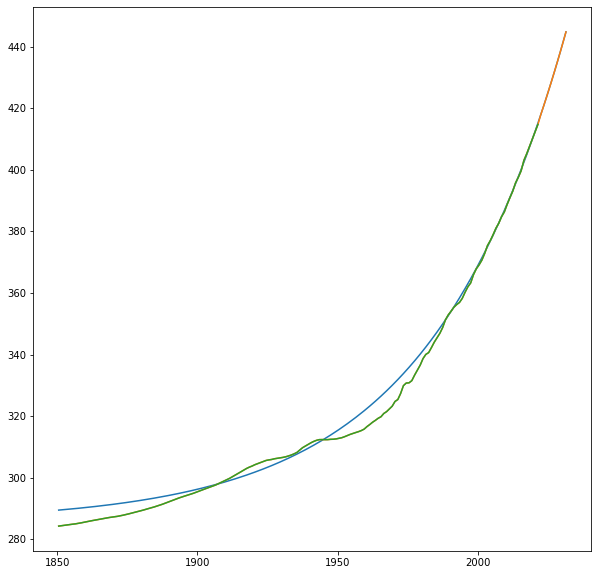

In [7]:
plt.figure(figsize=(10,10))
plt.plot(date_iaf, [fit(i) for i in range(0, len(atmco2))])
plt.plot(date_iaf, atmco2)
plt.plot(date_iaf[0:len(atmco2_data)], atmco2_data)

(370.0, 450.0)

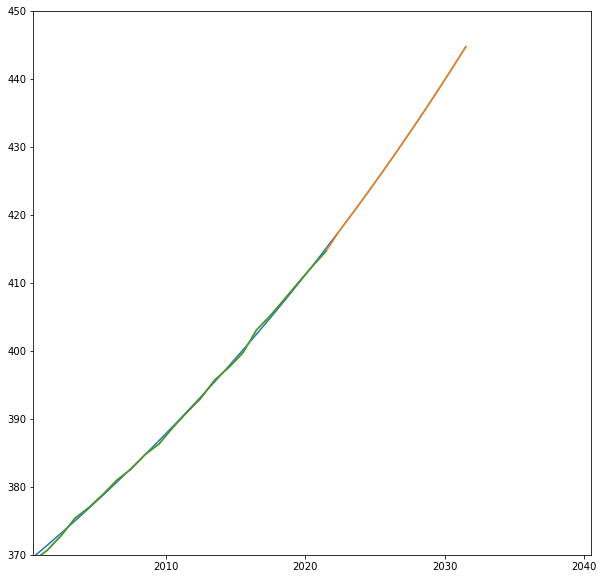

In [8]:
plt.figure(figsize=(10,10))
plt.plot(date_iaf, [fit(i) for i in range(0, len(atmco2))])
plt.plot(date_iaf, atmco2)
plt.plot(date_iaf[0:len(atmco2_data)], atmco2_data)
plt.xlim([DatetimeNoLeap(2000, 7, 1), DatetimeNoLeap(2040, 7, 1)])
plt.ylim([370, 450])

In [9]:
# res_list = ['1','025','01']

for ir in range(np.size(res_list)):
    if res_list[ir] == '1':
        ds_tar = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_20201102/mom_1deg/ocean_temp_salt.res.nc')
    elif res_list[ir] == '025':
        ds_tar = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_20201102/mom_025deg/ocean_temp_salt.res.nc')
    elif res_list[ir] == '01':
        ds_tar = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_20201102/mom_01deg/ocean_temp_salt.res.nc')
    ds_tar = ds_tar.rename({'ZT': 'st_ocean', 'GRID_Y_T': 'yt_ocean', 'GRID_X_T':'xt_ocean'})

    ds_tar = ds_tar.drop_dims('st_ocean')
    for v in ['time','time_bounds']:
        try:
            ds_tar = ds_tar.drop_vars(v)
        except ValueError:
            pass
    ds_tar = ds_tar.rename(({'xt_ocean':'grid_x_T', 'yt_ocean':'grid_y_T'}))
    ds_tar.attrs.pop('history', None)

    #RYF first
    #RYF only has two dates (the same concentration is used throughout the simulation.)    
    date_ryf = [
        DatetimeNoLeap(1800,7,1),
        DatetimeNoLeap(2101,7,1)
    ]    
    co2_3d = np.zeros((np.size(date_ryf),np.size(ds_tar.grid_y_T),np.size(ds_tar.grid_x_T)))
    #take the average of OMIP2 protocol CO2 between 1957-1958. fixed value is given to both RYF and nat_co2/dic
    co2_fix = np.mean(atmco2[1957-1850:1958+1-1850])
    co2_3d[:,:,:] = co2_fix
    ds_tar = ds_tar.assign_coords({"time":date_ryf})
    ds_tar['co2'] = xr.DataArray(co2_3d,dims=['time','grid_y_T','grid_x_T'])
    ds_tar['co2'].attrs = {'long_name': 'atmospheric CO2 concentration', 'units': 'ppm'}
    ds_tar.attrs['source'] = 'mean of OMIP2 protocol CO2 between 1957-58 (for repeat-year forcing)'
    ds_tar.to_netcdf(tmppath+'co2_ryf_'+res_list[ir]+'deg.nc',
                     unlimited_dims='time',
                     encoding={'co2':{'_FillValue': None,'zlib': True,'complevel': 9},'time':{'_FillValue':None,'dtype':'float64'}})
    
    ds_tar = ds_tar.drop_vars(['co2','time'])
    
    #IAF next
    co2_3d = np.zeros((np.size(date_iaf),np.size(ds_tar.grid_y_T),np.size(ds_tar.grid_x_T)))
    for it, atmco2i in enumerate(atmco2):
        co2_3d[it,:,:] = atmco2i
    
    ds_tar = ds_tar.assign_coords({"time":date_iaf})
    ds_tar['co2'] = xr.DataArray(co2_3d,dims=['time','grid_y_T','grid_x_T'])
    ds_tar['co2'].attrs = {'long_name': 'atmospheric CO2 concentration', 'units': 'ppm'}
    ds_tar.attrs['source'] = 'OMIP2 protocol until 2014. From 2015-2021, use the global average data from https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_annmean_gl.txt (as of 30 Jun 15:43:11 2022). For 2022 and beyond, use exponential extrapolation from final 20 years of data.'
    ds_tar.to_netcdf(tmppath+'co2_iaf_'+res_list[ir]+'deg.nc',
                     unlimited_dims='time',
                     encoding={'co2':{'_FillValue': None,'zlib': True,'complevel': 9},'time':{'_FillValue':None,'dtype':'float64'}})
    print(res_list[ir],'done')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


01 done


In [11]:
%%bash -s "$tmppath" "{" ".join(res_list)}"
cd $1
for ir in $2
do
    for it in iaf ryf
    do
        filename=co2_${it}_${ir}deg.nc
        ncatted -a cartesian_axis,grid_x_T,c,c,"X" $filename
        ncatted -a cartesian_axis,grid_y_T,c,c,"Y" $filename
    done
    echo $ir,done
done

01,done


# Creation of `bgc_param.nc`

### Define parameter values.
- For the names and units of these parameters, see Table of Supporting Information of Hayashida et al. (2020): Background nutrient concentration determines phytoplankton bloom response to marine heatwaves. Global Change Biology. https://doi.org/10.1111/gcb.15255
- However, note that units given below may be different from Table of Hayashida et al. (2020), because the model wants them in SI. For example, `abio = 0.27 d-1` in Hayashida et al. (2020), but `abio = 3.125e-6 s-1` in `bgc_param.nc` below. Parameters are given in the same units as Ziehn et al (2020) in `param_list_Ziehn2020`.
- The parameter values specifed below are identical to those of Ziehn et al. (2020): The Australian Earth System Model: ACCESS-ESM1.5. Journal of Southern Hemisphere Earth Systems Science. https://doi.org/10.1071%2Fes19035, except for `nat_co2`.
- `nat_co2` is the fixed atmospheric co2 concentration (ppm) applied to `dic`. Typically this is set to a pre-industrial co2 value, as long as `dic` is representative of natural DIC. However, in some applications, you might prescribe different values. We use `nat_co2`=284.32, which is the value used in the OMIP-BGC protocol (Orr et al. 2017, GMD).

In [12]:
param_list = [
    # Phytoplankton parameters
 ['alphabio', 2.96296e-6, {'long_name': 'Initial slope of P-I curve', 'units': 'm^2/W/s'}],
 ['parbio', 0.43, {'long_name': 'Photosynthetically active radiation', 'units': '1'}],
 ['abio', 3.125e-6, {'long_name': 'Phytoplankton maximum growth rate parameter a', 'units': '1/s'}],
 ['bbio', 1.066,  {'long_name': 'Phytoplankton maximum growth rate parameter b', 'units': '1'}],
 ['cbio', 1, {'long_name': 'Phytoplankton maximum growth rate parameter c', 'units': '1/K'}],
 ['k1bio', 0.7, {'long_name': 'Phytoplankton half saturation constant for N uptake', 'units': 'mmol N m^-3'}],
 ['muepbio', 4.62963e-7, {'long_name': 'Phytoplankton mortality', 'units': '1/s'}],
 ['muepsbio', 2.89352e-6, {'long_name': 'Phytoplankton quadratic mortality', 'units': '1/(mmol N m^-3)/s'}],
    # Zooplankton parameters
 ['gam1bio', 0.925, {'long_name': 'Zooplankton assimilation efficiency', 'units': '1'}],
 ['gbio', 1.82292e-5, {'long_name': 'Zooplankton maximum grazing rate', 'units': '1/s'}],
 ['epsbio', 1.85185e-5, {'long_name': 'Zooplankton prey capture rate', 'units': '1/(mmol N m^-3)/s'}],
 ['muezbio', 3.93519e-6, {'long_name': 'Zooplankton quadratic mortality', 'units': '1/(mmol N m^-3)/s'}],
 ['gam2bio', 1.15741e-7, {'long_name': 'Zooplankton excretion', 'units': '1/s'}],
    # Detritus parameters
 ['muedbio', 5.55556e-7, {'long_name': 'Detritus remineralisation rate for <180 m; value for >=180m is half of this', 'units': '1/s'}], # Detritus remineralisation rate for (>=180 m) is hard-coded to be muedbio/2
 ['muedbio_sed', 2.31481e-7, {'long_name': 'Detritus remineralisation rate in sediments', 'units': '1/s'}], # would normally equal muedbio, but we use this value to be consistent with what is in ESM1.5 (undocumented in Ziehn et al 2020)
 ['wdetbio', 2.77778e-4, {'long_name': 'Detritus sinking velocity', 'units': 'm/s'}], # matches Ziehn et al 2020 but differs from Hayashida et al (2020)
    # CaCO3 parameters
 ['muecaco3', 1.9838e-8, {'long_name': 'CaCO3 remineralisation rate', 'units': '1/s'}], # CaCO3 remineralisation rate (matches 0.001714 day-1 in Ziehn et al 2020; differs from Hayashida et al 2020)
 ['muecaco3_sed', 4.05093e-8, {'long_name': 'CaCO3 remineralisation rate in sediments', 'units': '1/s'}],
 ['wcaco3', 6.94444e-5, {'long_name': 'CaCO3 sinking velocity', 'units': 'm/s'}], # matches Ziehn et al 2020 but differs from Hayashida et al (2020)
 ['f_inorg', 0.062, {'long_name': 'CaCO3 inorganic fraction', 'units': '1'}], # CaCO3 inorganic fraction
    # Fe paramaters
 ['tscav_fe', 3.17098e-8, {'long_name': 'Iron scavenging rate', 'units': '1/s'}],
 ['fe_bkgnd', 0.6, {'long_name': 'Background iron concentration', 'units': 'umol Fe m^-3'}],
    # Others
 ['kcbio', 21.2766, {}], # required as an input in WOMBAT but not actually used; not in Ziehn et al (2020) or Hayashida et al (2020) tables
 ['kwbio', 25, {}], # required as an input in WOMBAT but not actually used; not in Ziehn et al (2020) or Hayashida et al (2020) tables
 ['nat_co2', 284.32, {'long_name': 'Natural atmospheric CO2 concentration', 'units': 'ppm'}], # 284.32 in the OMIP-BGC protocol (Orr et al. 2017, GMD)
]

In [13]:
# Show parameters in same units as Ziehn et al. (2020) https://doi.org/10.1071%2Fes19035 for checking against their table 2
param_list_Ziehn2020 = [ x if x[0] in ['parbio', 'bbio', 'cbio', 'k1bio', 'gam1bio', 'f_inorg', 'fe_bkgnd', 'nat_co2']
                        else [x[0], x[1]*24*60*60, x[2], 'converted to per-day'] # convert from per-day to per-second
                        for x in param_list ]
param_list_Ziehn2020

[['alphabio',
  0.25599974400000003,
  {'long_name': 'Initial slope of P-I curve', 'units': 'm^2/W/s'},
  'converted to per-day'],
 ['parbio',
  0.43,
  {'long_name': 'Photosynthetically active radiation', 'units': '1'}],
 ['abio',
  0.27,
  {'long_name': 'Phytoplankton maximum growth rate parameter a',
   'units': '1/s'},
  'converted to per-day'],
 ['bbio',
  1.066,
  {'long_name': 'Phytoplankton maximum growth rate parameter b',
   'units': '1'}],
 ['cbio',
  1,
  {'long_name': 'Phytoplankton maximum growth rate parameter c',
   'units': '1/K'}],
 ['k1bio',
  0.7,
  {'long_name': 'Phytoplankton half saturation constant for N uptake',
   'units': 'mmol N m^-3'}],
 ['muepbio',
  0.040000003199999995,
  {'long_name': 'Phytoplankton mortality', 'units': '1/s'},
  'converted to per-day'],
 ['muepsbio',
  0.25000012800000004,
  {'long_name': 'Phytoplankton quadratic mortality',
   'units': '1/(mmol N m^-3)/s'},
  'converted to per-day'],
 ['gam1bio',
  0.925,
  {'long_name': 'Zooplankton 

### Create data

In [14]:
# res_list = ['1','025','01']

for ir in range(np.size(res_list)):
    if res_list[ir] == '1':
        ds_tar = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_20201102/mom_1deg/ocean_temp_salt.res.nc')
    elif res_list[ir] == '025':
        ds_tar = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_20201102/mom_025deg/ocean_temp_salt.res.nc')
    elif res_list[ir] == '01':
        ds_tar = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_20201102/mom_01deg/ocean_temp_salt.res.nc')
    ds_tar = ds_tar.rename({'ZT': 'st_ocean', 'GRID_Y_T': 'yt_ocean', 'GRID_X_T':'xt_ocean'})

    ds_tar['temp'] = ds_tar['temp'].isel(st_ocean=0,drop=True)
    ds_tar = ds_tar.drop_dims('st_ocean')
    try:
        ds_tar = ds_tar.drop_vars('time_bounds')
    except ValueError:
        pass
    ds_tar = ds_tar.rename(({'xt_ocean':'grid_x_T', 'yt_ocean':'grid_y_T'}))
    for it in range(np.size(param_list,0)):
        #where() is needed to remove the land mask.
        ds_tar[param_list[it][0]] = ds_tar['temp'].where(ds_tar['temp']>0,0)*0 + param_list[it][1]
        ds_tar[param_list[it][0]].attrs = param_list[it][2]
    ds_tar = ds_tar.drop_vars('temp')
    ds_tar.attrs.pop('history', None)
    ds_tar.attrs['source'] = 'Ziehn et al. (2020): The Australian Earth System Model: ACCESS-ESM1.5. J. Southern Hem. Earth Syst. Sci. https://doi.org/10.1071%2Fes19035, except for nat_co2 which is from the OMIP-BGC protocol (Orr et al. 2017, GMD)'
    comp = dict(_FillValue=-1e34, missing_value=-1e34)
    encoding = {var: comp for var in ds_tar.data_vars}

# convert units of 'degree_' to 'degrees_' so MOM will be able to infer the axis meaning
# https://github.com/mom-ocean/MOM5/blob/1d9af9d262b/src/shared/axis_utils/axis_utils.F90#L92-L99
    for dim in ds_tar.dims:
        try:
            units = ds_tar[dim].attrs['units'].lower()
            if units.startswith('degree_'):
                ds_tar[dim].attrs['units'] = units.replace('degree_', 'degrees_', 1)
        except KeyError:
            pass

    ds_tar.to_netcdf(tmppath+'bgc_param_'+res_list[ir]+'deg.nc',
                     encoding=encoding,
                     unlimited_dims='time')#,encoding={'time':{'_FillValue':None,'dtype':'float64'}})
    print(res_list[ir],'done')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


01 done


In [15]:
%%bash -s "$tmppath" "{" ".join(res_list)}"
cd $1
for ir in $2
do
    filename=bgc_param_${ir}deg.nc
    ncatted -a cartesian_axis,grid_x_T,c,c,"X" $filename
    ncatted -a cartesian_axis,grid_y_T,c,c,"Y" $filename
    ncks -O -L 9 $filename $filename
    echo $ir,done
done

01,done


# Creation of `dust.nc`
1. The original source file for dust input is not available, so use the 1-degree interpolated file as input. the method is described in Mongin et al. (2011), https://doi.org/10.1016/j.dsr2.2011.06.001.

In [16]:
# res_list = ['1','025','01']

for ir in range(np.size(res_list)):
    #read target grid
    if res_list[ir] == '1':
        ds_tar = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_20201102/mom_1deg/ocean_temp_salt.res.nc')
        ds_gri = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc')
    elif res_list[ir] == '025':
        ds_tar = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_20201102/mom_025deg/ocean_temp_salt.res.nc')
        ds_gri = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc')        
    elif res_list[ir] == '01':
        ds_tar = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_20201102/mom_01deg/ocean_temp_salt.res.nc')
        ds_gri = xr.open_dataset('/g/data/ik11/grids/ocean_grid_01.nc')        
    #rename to lon and lat so that xesmf understands
    ds_gri = ds_gri.rename({'geolon_t': 'lon', 'geolat_t': 'lat'})
    ds_tar = ds_tar.rename({'ZT': 'st_ocean', 'GRID_Y_T': 'yt_ocean', 'GRID_X_T':'xt_ocean'})

    ds_in = xr.open_dataset(inpath+'dust.nc')
    ds_gri_in = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc')
    ds_gri_in = ds_gri_in.rename({'geolon_t': 'lon', 'geolat_t': 'lat'})
    
    ds_tar['temp'] = ds_tar['temp'].isel(st_ocean=0,drop=True)
    ds_tar = ds_tar.drop_dims('st_ocean')
    for v in ['time','time_bounds']:
        try:
            ds_tar = ds_tar.drop_vars(v)
        except ValueError:
            pass
    ds_tar = ds_tar.drop_vars('temp')
    ds_tar = ds_tar.assign_coords({"time":ds_in['time']})
    ds_tar['lon'] = (['yt_ocean','xt_ocean'],ds_gri['lon'].values)
    ds_tar['lat'] = (['yt_ocean','xt_ocean'],ds_gri['lat'].values)
    ds_in['lon'] = (['yt_ocean','xt_ocean'],ds_gri_in['lon'].values)
    ds_in['lat'] = (['yt_ocean','xt_ocean'],ds_gri_in['lat'].values)

    regridder = xe.Regridder(ds_gri_in,ds_gri,method='bilinear',periodic=True)
    ds_tar['dust'] = (['time','yt_ocean','xt_ocean'],regridder(ds_in['dust']).values)    
    ds_tar = ds_tar.rename(({'xt_ocean':'grid_x_T', 'yt_ocean':'grid_y_T'}))
    #some interpolated values are NaNs, so interpolate_na with the following options to fill in NaNs.
    #dim='st_ocean' is essential. 'xt_ocean' produces NaNs.
    #method='nearest' is essential. 'linear' gives extreme values.
    #fill_value='extrapolate' is essential. without it, still NaNs exist.
    ds_tar['dust'] = ds_tar['dust'].interpolate_na(dim='time',method='nearest',fill_value="extrapolate")
    print(['input: ',ds_in['dust'].mean(),ds_in['dust'].min(),ds_in['dust'].max()])
    print(['output: ',ds_tar['dust'].mean(),ds_tar['dust'].min(),ds_tar['dust'].max()])

# convert units of 'degree_' to 'degrees_' so MOM will be able to infer the axis meaning
# https://github.com/mom-ocean/MOM5/blob/1d9af9d262b/src/shared/axis_utils/axis_utils.F90#L92-L99
    for dim in ds_tar.dims:
        try:
            units = ds_tar[dim].attrs['units'].lower()
            if units.startswith('degree_'):
                ds_tar[dim].attrs['units'] = units.replace('degree_', 'degrees_', 1)
        except KeyError:
            pass

    ds_tar.attrs.pop('history', None)
    ds_tar.to_netcdf(tmppath+'dust_'+res_list[ir]+'deg.nc',
                     unlimited_dims='time',
                     encoding={'dust':{'zlib': True,'complevel': 1,
                                       '_FillValue':-1.e34, 'missing_value':-1.e34}})
    print(res_list[ir],'done')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xesmf/frontend.py:598: UserWarning: Using dimensions ('grid_y_T', 'grid_x_T') from data variable dust as the horizontal dimensions for the regridding.
  warnings.warn(
tornado.application - ERROR - Exception in callback functools.partial(<bou

['input: ', <xarray.DataArray 'dust' ()>
array(5.21357542e-08), <xarray.DataArray 'dust' ()>
array(0.), <xarray.DataArray 'dust' ()>
array(2.1554396e-05)]
['output: ', <xarray.DataArray 'dust' ()>
array(3.92675238e-08), <xarray.DataArray 'dust' ()>
array(0.), <xarray.DataArray 'dust' ()>
array(2.12758077e-05)]
01 done


# Creation of `csiro_bgc_sediment.res.nc`
1. for simplicity, initialise with zero values everywhere.
1. the x and y dimensions of the input file are not helpful (given indices instead of actual lon/lat values), so replace them with dust.nc for interpolation purposes.
1. This script relies on `csiro_bgc.res.nc`, so make sure to compute this after creating `csiro_bgc.res.nc`.

In [17]:
# res_list = ['1','025','01']

for ir in range(np.size(res_list)):
    ds_in = xr.open_dataset(tmppath+'csiro_bgc.res_'+res_list[ir]+'deg.nc')
    ds_tar = ds_in['phy'].isel(zaxis_1=0,drop=True)
    ds_tar = ds_tar*0
    ds_tar = ds_tar.rename('caco3_sediment')

# convert units of 'degree_' to 'degrees_' so MOM will be able to infer the axis meaning
# https://github.com/mom-ocean/MOM5/blob/1d9af9d262b/src/shared/axis_utils/axis_utils.F90#L92-L99
    for dim in ds_tar.dims:
        try:
            units = ds_tar[dim].attrs['units'].lower()
            if units.startswith('degree_'):
                ds_tar[dim].attrs['units'] = units.replace('degree_', 'degrees_', 1)
        except KeyError:
            pass

    ds_tar.to_netcdf(tmppath+'csiro_bgc_sediment.res_'+res_list[ir]+'deg.nc',unlimited_dims='Time',encoding={'Time':{'_FillValue':None,'dtype':'float64'}})
    print(res_list[ir],'done')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


01 done


In [18]:
%%bash -s "$tmppath" "{" ".join(res_list)}"
cd $1
for ir in $2
do
    filename=csiro_bgc_sediment.res_${ir}deg.nc
    ncap2 -O -s 'det_sediment=caco3_sediment' $filename $filename
    ncatted -a cartesian_axis,xaxis_1,c,c,"X" $filename
    ncatted -a cartesian_axis,yaxis_1,c,c,"Y" $filename
    ncks -O -L 9 $filename $filename
done

# Update `o2i.nc` and `i2o.nc`
- two bgc tracers added to each file.
- wind speed is added to `i2o.nc` for gas flux calculation.
- these are the initial conditions for fluxes. set to zeros for simplicity.

In [19]:
%%bash -s "$basepath" "{" ".join(res_list)}"
basepath=$1
for ir in $2
do
    cd $basepath${ir}deg/
    ncap2 -O -s 'ssn_i=sst_i*0' o2i.nc o2i.nc
    ncap2 -O -s 'ssalg_i=sst_i*0' o2i.nc o2i.nc
    ncap2 -O -s 'wnd10_io=licefh_io*0' i2o.nc i2o.nc
    ncap2 -O -s 'nit_io=wnd10_io*0' i2o.nc i2o.nc
    ncap2 -O -s 'alg_io=wnd10_io*0' i2o.nc i2o.nc
done

# Copy the regridded files to their respective destinations.
1. the regridded files will be copied to each resolution directory and given the same file names (so that no need to customise ocean/field_table for each resolution).

In [10]:
%%bash -s "$tmppath" "{" ".join(res_list)}"
cd $1
for ir in $2
do
    for it in bgc_param co2_iaf co2_ryf dust csiro_bgc.res csiro_bgc_sediment.res
    do
        if [ -f ${it}_${ir}deg.nc ]; then
            cp -p ${it}_${ir}deg.nc ../${ir}deg/${it}.nc
        fi
    done
done

# That's it! If you are happy with the output stored in `1deg, 025deg, 01deg`, then delete `tmp`.
# When it's completely finalised, run `finalise.sh`.

# Pre-processing of input and reference grid data (NOT NECESSARY, as these data already exist, but keeping it for reproducibility).

In [ ]:
#Download GLODAPv2 2016b and OMIP archives of WOA13v2 (no3, o2) and FEMIP (fe)
#Extract GLODAPv2
%%bash -s "$inpath"
cd $1
wget https://www.nodc.noaa.gov/archive/arc0107/0162565/1.1/data/0-data/mapped/GLODAPv2.2016b_MappedClimatologies.tar.gz
tar -xvf GLODAPv2.2016b_MappedClimatologies.tar.gz
wget https://vesg.ipsl.upmc.fr/thredds/fileServer/IPSLFS/jomce/OMIP/initconds/FEMIP_model_median_iron_2016.nc
wget https://vesg.ipsl.upmc.fr/thredds/fileServer/IPSLFS/jomce/OMIP/initconds/woa13_oxygen_OMIPinit.nc
wget https://vesg.ipsl.upmc.fr/thredds/fileServer/IPSLFS/jomce/OMIP/initconds/woa13_nitrate_OMIPinit.nc

In [ ]:
#Extrapolate over land
%%bash -s "$inpath"
cd $1
cdo -O fillmiss woa13_oxygen_OMIPinit.nc woa13_oxygen_OMIPinit_fillmiss.nc
cdo -O fillmiss woa13_nitrate_OMIPinit.nc woa13_nitrate_OMIPinit_fillmiss.nc
cdo -O fillmiss FEMIP_model_median_iron_2016.nc FEMIP_model_median_iron_2016_fillmiss.nc
for iv in oxygen NO3 PI_TCO2 TCO2 TAlk
do
    filename=GLODAPv2.2016b.${iv}
    cdo -O fillmiss GLODAPv2.2016b_MappedClimatologies/${filename}.nc ${filename}_fillmiss.nc
done 

In [32]:
# Apply fillmiss for `adic` and `dic` of ACCESS-OM2 OMIP2 output. 
# For adic and alk, use the 1-deg omip2 cycle 5 restart 304. 
# Because restart files have weird values over land, i cannot do `cdo fillmiss`. 
# To resolve this issue, i need to first apply the landsea mask 
# and also give appropriate grid coordinates based on an output file.
ds_in = xr.open_dataset('/g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle5/restart304/ocean/csiro_bgc.res.nc')
ds_ou = xr.open_dataset('/g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle5/output304/ocean/ocean_bgc_ann.nc')
ds_ou['adic'] = ds_ou['adic'].where(ds_ou['adic']!=ds_ou['adic'],ds_in['adic'].values)
ds_ou['alk'] = ds_ou['alk'].where(ds_ou['alk']!=ds_ou['alk'],ds_in['alk'].values)
ds_ou.to_netcdf(inpath+'1deg_jra55_iaf_omip2_cycle5_restart304_csiro_bgc.res.nc')

In [ ]:
#Extrapolate over land
%%bash -s "$inpath"
cd $1
cdo -fillmiss 1deg_jra55_iaf_omip2_cycle5_restart304_csiro_bgc.res.nc 1deg_jra55_iaf_omip2_cycle5_restart304_csiro_bgc.res_fillmiss.nc


In [ ]:
#Create a reference grid file for each resolution (used as a target grid for regridding)
ncks -d time,1 -v temp /g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle6/output365/ocean/ocean_month.nc 1deg/ocean_grid_xyz.nc
ncks -d time,1 -v temp /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output365/ocean/ocean_month.nc 025deg/ocean_grid_xyz.nc
ncks -d time,1 -v temp /g/data/ik11/outputs/access-om2-01/01deg_jra55v140_iaf_cycle3/output700/ocean/ocean-3d-temp-1-daily-mean-ym_2011_01.nc 01deg/ocean_grid_xyz.nc
